In [115]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.
dep_path = "../MOD/Julia/"
include("$(dep_path)NewTypes.jl")
include("$(dep_path)BitStringOps.jl")
include("$(dep_path)Measurements.jl")
include("$(dep_path)MICModels.jl")
include("$(dep_path)ModelRuns.jl")
include("$(dep_path)HelperTools.jl")
include("$(dep_path)Iterators.jl")
include("$(dep_path)ZassenhausFull.jl");

# Zassenhaus algorithm

The aim of this file is to benchmark and investigate the full implementation of the Zassenhaus algorithm, and its application to extracting stabilizers that connect correlated points in late time MOD states.

### Zassenhaus in QuantumClifford

1. Define 'Jovan's f and h functions' on a quadrupled system as $f: g \rightarrow g \otimes g \otimes g \otimes g$ and $h: g \rightarrow g \otimes g \otimes e \otimes e$. These effectively construct the Zassenhaus matrix (https://en.wikipedia.org/wiki/Zassenhaus_algorithm), with a doubling to 'abelianise' the groups.

2. For $G_1 = \langle q_1 \rangle$ and $G_2 = \langle q_2 \rangle$, the Zassenhaus matrix is then the matrix of stabilisers of the state $\langle f(G_1), h(G_2) \rangle$.

3. Then tracing out the first $2N$ qubits yields a state generated by stabilisers of the form $e\otimes e \otimes q \otimes q$ on the remaining qubits, where $\left< q \right> = G_1 \cap G_2$. We then just extract the stabilisers $q$ to obtain the intersection $G_1 \cap G_2$.

### Application of Zassenhaus to correlators / condensation
We obtain the correlators as follows: consider a state $\rho$ given by a stabilizer group $S$. Consider a `representative string' $f_\gamma$, either bosonic or fermionic, between points $i$ and $j$ considered. Define
\begin{align}
F_{ij} &= \left< f_\gamma, S_{TC}, \mathcal{L}_{TC} \right> \\
T &= \left<  S_{TC}, \mathcal{L}_{TC} \right>,
\end{align}
for $S_{TC}$ and $\mathcal{L}_{TC}$ Toric Code stabilizers and logicals, respectively. Then if $\dim(S \cap F_{ij}) > \dim(S \cap T)$, the stabilizer group of our state $\rho$ contains a bosonic/fermionic string connecting points $i$ and $j$, so that $f^2_{ij} = 1$. It is (some of) these strings that we extract. We do so by looping over the generators of $S \cap F_{ij}$ and projecting the state $S \cap T$ onto that generator. If doing so increases the dimension of $S \cap T$, then the generator in question is contained in $S \cap F_{ij}$ but not in $S \cap T$, and hence connects points $i$ and $j$.



## Benchmarking: 4 qubits

### Zassenhaus benchmarking

As a check, I will consider $1D$ 4-qubit systems with given generators, for which the intersections can be obtained by inspection. I will choose one of the sets of 'stabilizers' to be one which doesn't internally commute, because this will be the case for calculating correlators. This means I can't write them as <code>S""</code> but need to make lists of stabilizers, and only create a <code>MixedDestabilizer</code> state after quadrupling the system size.

Then I will consider an example where the intersection is trivial (meaning the partial trace yields the maximally mixed state), to check if the method handles this well.

In [21]:
# Stabilizer groups as lists (not formally stabilizers as they don't have to internally commute)

# By inspection their intersection is ZIIZ

nbits = 4

stabs_1 = [QuantumClifford.P"XXXX", 
           QuantumClifford.P"ZZII",
           QuantumClifford.P"IZZI",
           QuantumClifford.P"IIZZ"]

stabs_2 = [QuantumClifford.P"XXII", 
           QuantumClifford.P"ZIIZ",
           QuantumClifford.P"ZZZI"]

intersect = zassenhaus_intersect(stabs_1, stabs_2, nbits)

println(stabilizerview(intersect), ", as expected.")


+ Z__Z, as expected.


In [22]:
# Same thing but now for sets with a trivial intersection
nbits = 4

stabs_1 = [QuantumClifford.P"XXXX", 
           QuantumClifford.P"ZZII",
           QuantumClifford.P"IIZZ"]

stabs_2 = [QuantumClifford.P"XXII", 
           QuantumClifford.P"ZIIZ",
           QuantumClifford.P"ZZZI"]

intersect = zassenhaus_intersect(stabs_1, stabs_2, nbits)

# As a stabilizer state, the intersection should be the maximally mixed state on 4 qubits
intersect == maximally_mixed_state(nbits)


true

### Extracting 'extra stabilizers'

Next a benchmarking of the function <code>condensation_strings_full</code>. I am not using the function explicitly because it is optimized for the toric code / stabilizer state setup. However, the block of code which extracts the `extra' stabilizers is exactly the same.

In [24]:
# Consider these two states on 4 qubits. State 2 is equivalent to state 1, adding the extra generator XXXX. We want to extract that 'extra stabilizer'.

stabs_1 = S"ZZII
            ZIIZ
            IIZZ"
ms1 = MixedDestabilizer(s1)

stabs_2 = S"ZIZI
            XXXX
            XYYX
            IIZZ"
ms2 = MixedDestabilizer(s2)

# loop over the larger state and see if adding any of its stabilizers to the smaller state increase the size of the smaller state
for stab in stabilizerview(ms2)
    test_state = copy(ms1)
    project!(test_state, stab, keep_result=false)
    if size(stabilizerview(test_state))[1] > size(stabilizerview(ms1))[1]
        println("added stabilizer ", stab, ", as expected.\n")
    end
end


added stabilizer + XXXX, as expected.



### A word of caution

Note: this simple implementation shows the dependence of the method on QuantumClifford's internal canonicalizationthat is performed on MixedDestabilizer states. Looking at the list "stabs_2", we could have added either XXXX or XYYX to the first group to obtain the second group. However, the method only returns XXXX. This is because, after canonicalization, XYYX is no longer used as a generator.

The lesson is that, while we will always find at least one stabilizer with this method, both the number of stabilizers we find, and their exact form, depend on the list of generators we choose for the group and hence, in practice, on the canonicalization procedure of QuantumClifford. However, I don't think this is an issue, because it comes down to choosing one of several topologically equivalent operators (connected by string deformations, adding loops).

## Application to monitored TC in percolation regime

Obtain a late time monitored TC in the boson condensing phase, with parameters
\begin{align}
p_B &= 0.4 \\
p_F &= 0 \\
p_{TC} &= 1 - p_B - p_F.
\end{align}

The code below obtains the state, and measures correlation functions, to show that we are indeed in the boson condensing phase.

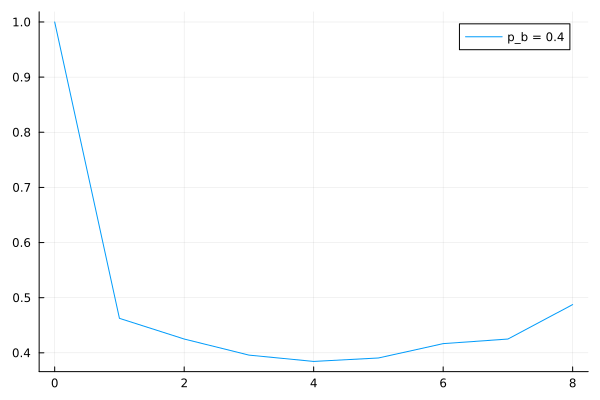

In [27]:
# Take a toric code in the bosonic condensing phase (code from Jovan)
L = 9
d = 3 # thickness of subdivision


system = Init_EdgeSquareLattice_KitaevDoNuT(L, d)

t_mmt = Array{Int}(20:20:400).+50
n_t = length(t_mmt)
t_old = 0
e_deformator = get_e_deformator(system)
f_deformator = get_f_deformator(system)

all_r = []
for i = 1:L
    for j = 1:L
        x_i = i - 1 
        y_i = j - 1
        push!(all_r, taxi_metrix_torus((0, 0), (x_i, y_i), L, L))
    end
end

r_max, _ = findmax(all_r)
plot_x = [0:r_max]

# number of points at same distance
norm_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        norm_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += 1
    end
end

# Setup Done

scatter()

# Iteration 1

p_f = 0
p_b = 0.4
p_tc = 1 - p_f - p_b
stab_distro = Categorical([p_tc/2, p_tc/2, p_b, 0, p_f])
state = toric_code_GS(system)

corr_function = zeros(Float64, L, L)

for t_index in 1:n_t
    t_evol = t_mmt[t_index] - t_old
    t_old = t_mmt[t_index]
    state = iterate_measurements_only_fast!(state, system, () -> toric_code(system, stab_distro), t_evol)
    corr_function += general_zassenhaus_correlator(state, system, get_e_representative, e_deformator)
end

plot_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        plot_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += corr_function[i, j]/n_t
    end
end

plot!(plot_x, plot_y ./ norm_y, label = "p_b = $(p_b)")

### Example calculation
At a given time the origin may not be connected to any other point. The matrix below shows what sites the origin is correlated with.

In [28]:
display(general_zassenhaus_correlator(state, system, get_e_representative, e_deformator))

9×9 Matrix{Int64}:
 1  0  1  1  1  1  1  0  1
 0  1  1  1  0  0  1  1  1
 1  1  1  1  1  0  1  0  1
 0  0  1  1  1  1  1  1  1
 0  0  1  1  0  1  0  1  1
 0  0  0  1  1  1  1  1  1
 0  0  0  1  1  0  0  1  1
 0  0  1  1  1  1  0  0  0
 0  1  1  1  0  0  1  1  1

In [35]:
# Some general points
println("The state has ", size(stabilizerview(state))[1], " generators.\n")

# From the above matrix, we can pick a point that is correlated with the origin.
r_x = 2
r_y = 4

charge_representative = get_e_representative((r_x, r_y), system)
trivial_intersect = zassenhaus_intersect(e_deformator, stabilizerview(state), system.nbits)
string_intersect = zassenhaus_intersect(charge_representative, e_deformator, stabilizerview(state), system.nbits)

println("The intersection of toric code stabilizers with the state stabilizers has ", size(stabilizerview(trivial_intersect))[1], " generators.")
println("The intersection of boson string and toric code stabilizers with the state stabilizers has ", size(stabilizerview(string_intersect))[1], " generators.")
println("A bosonic string connecting sites (0,0) and ($r_x, $r_y) is contained within the stabilizer group of the state. The points are correlated.\n")

# We can also pick a point that is not correlated with the origin.
r_x = 1
r_y = 5

charge_representative = get_e_representative((r_x, r_y), system)
trivial_intersect = zassenhaus_intersect(e_deformator, stabilizerview(state), system.nbits)
string_intersect = zassenhaus_intersect(charge_representative, e_deformator, stabilizerview(state), system.nbits)

println("The intersection of toric code stabilizers with the state stabilizers has ", size(stabilizerview(trivial_intersect))[1], " generators.")
println("The intersection of boson string and toric code stabilizers with the state stabilizers has ", size(stabilizerview(string_intersect))[1], " generators.")
println("No bosonic string connecting sites (0,0) and ($r_x, $r_y) is contained within the stabilizer group of the state. The points are not correlated.")



The state has 162 generators.

The intersection of toric code stabilizers with the state stabilizers has 82 generators.
The intersection of boson string and toric code stabilizers with the state stabilizers has 83 generators.
A bosonic string connecting sites (0,0) and (2, 4) is contained within the stabilizer group of the state. The points are correlated.

The intersection of toric code stabilizers with the state stabilizers has 82 generators.
The intersection of boson string and toric code stabilizers with the state stabilizers has 82 generators.
No bosonic string connecting sites (0,0) and (1, 5) is contained within the stabilizer group of the state. The points are not correlated.


This shows that the method of obtaining full intersections agrees with Jovan's method as to whether or not points are correlated. I still need to have a think about why the intersections have rougly $L^2$ generators.

### Extracting stabilizers
Next we use the new functions to find 
- A list of stabilizers connecting correlated points
- The smallest such stabilizer

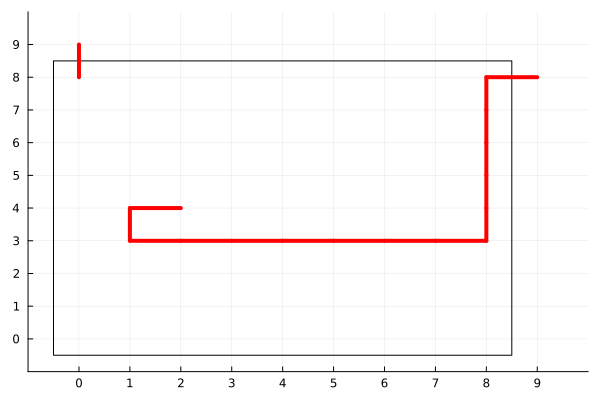

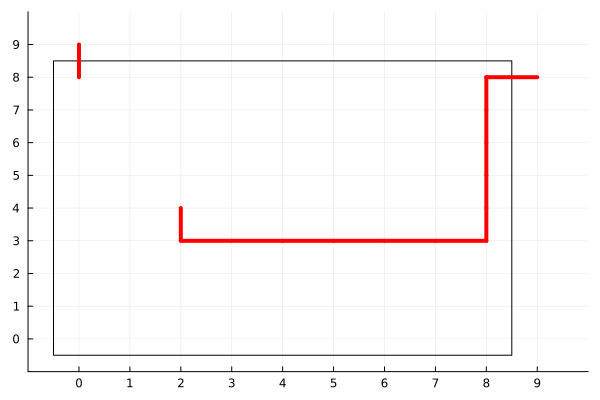

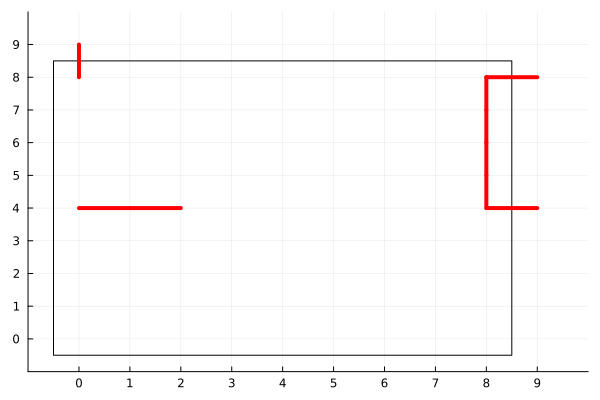

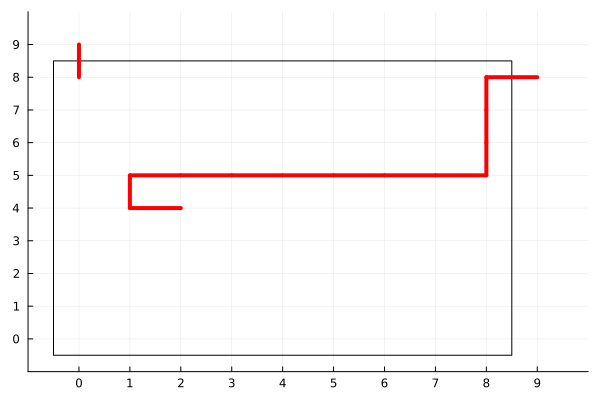

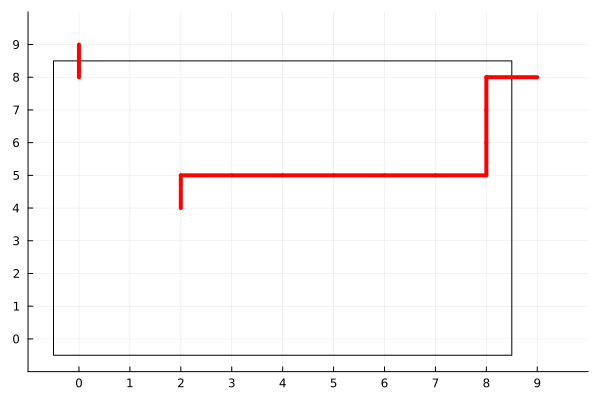

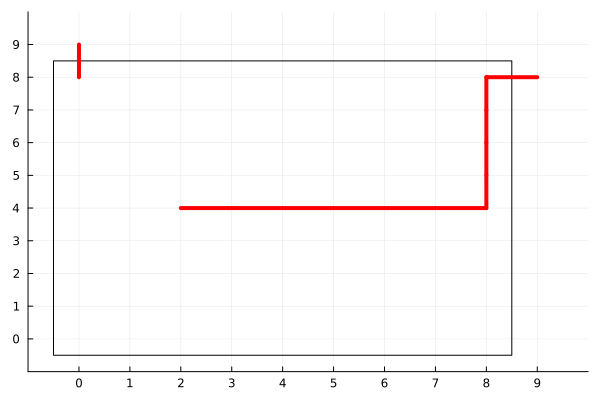

Shortest stabilizer between (0,0) and (2,4)



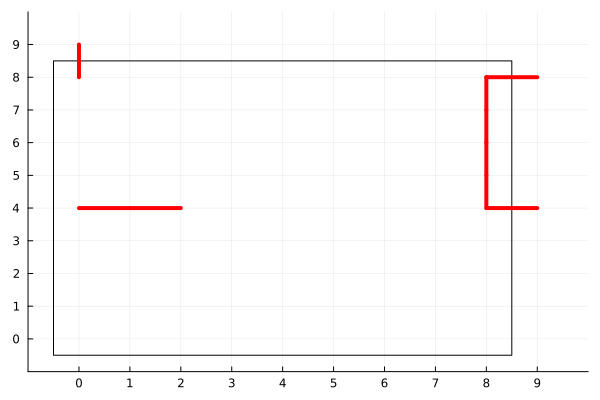

In [38]:
## Example 1: all strings between two points
strings = condensation_strings_full((2,4), state, system, get_e_representative, e_deformator)
for string in strings
    visualise_the_stabiliser(string, system)
end

## Example 2: the shortest string between two points
short_string = condensation_string_short((2,4), state, system, get_e_representative, e_deformator)
println("Shortest stabilizer between (0,0) and (2,4)\n")
visualise_the_stabiliser(short_string, system)


## Fermion condensation regime

Now use these methods to study fermion condensation. This first requires initializing a new system in the fermion condensing phase. I will use parameters
\begin{align}
p_B &= 0.15 \\
p_F &= 0.5 \\
p_{TC} &= 1 - p_B - p_F.
\end{align}



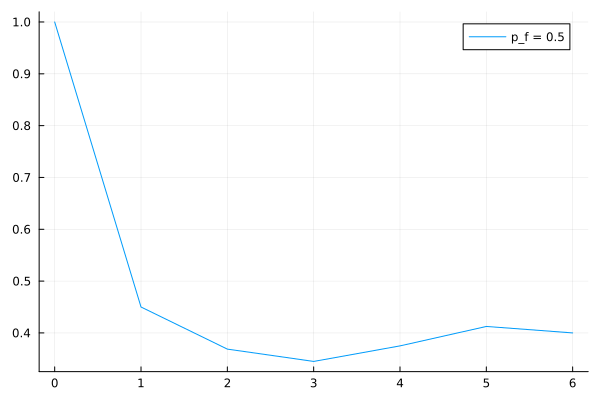

In [45]:
# Take a toric code in the bosonic condensing phase (code from Jovan)
L = 6
d = 3 # thickness of subdivision


fermion_system = Init_EdgeSquareLattice_KitaevDoNuT(L, d)

t_mmt = Array{Int}(20:20:400).+50
n_t = length(t_mmt)
t_old = 0
e_deformator = get_e_deformator(fermion_system)
f_deformator = get_f_deformator(fermion_system)

all_r = []
for i = 1:L
    for j = 1:L
        x_i = i - 1 
        y_i = j - 1
        push!(all_r, taxi_metrix_torus((0, 0), (x_i, y_i), L, L))
    end
end

r_max, _ = findmax(all_r)
plot_x = [0:r_max]

# number of points at same distance
norm_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        norm_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += 1
    end
end

# Setup Done

scatter()

# Iteration 1

p_f = 0.5
p_b = 0.15
p_tc = 1 - p_f - p_b
stab_distro = Categorical([p_tc/2, p_tc/2, p_b, 0, p_f])
fermion_state = toric_code_GS(fermion_system)

corr_function = zeros(Float64, L, L)

for t_index in 1:n_t
    t_evol = t_mmt[t_index] - t_old
    t_old = t_mmt[t_index]
    fermion_state = iterate_measurements_only_fast!(fermion_state, fermion_system, () -> toric_code(fermion_system, stab_distro), t_evol)
    corr_function += general_zassenhaus_correlator(fermion_state, fermion_system, get_f_representative, f_deformator)
end

plot_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        plot_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += corr_function[i, j]/n_t
    end
end

plot!(plot_x, plot_y ./ norm_y, label = "p_f = $(p_f)")

In [49]:
display(general_zassenhaus_correlator(fermion_state, fermion_system, get_f_representative, f_deformator))

6×6 Matrix{Int64}:
 1  1  0  1  0  1
 1  1  0  0  0  1
 1  0  0  0  1  1
 1  1  0  1  1  1
 1  1  1  0  0  0
 0  1  0  1  1  1

## Visualization

So we are in a condensing regime, so let's just plot some stabilizers connecting correlated points.

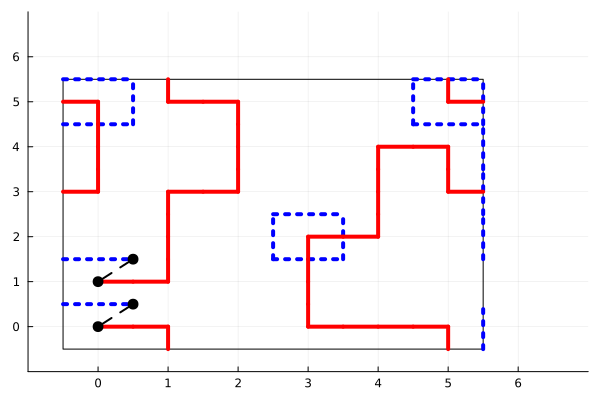

(0,1)

(2,0)



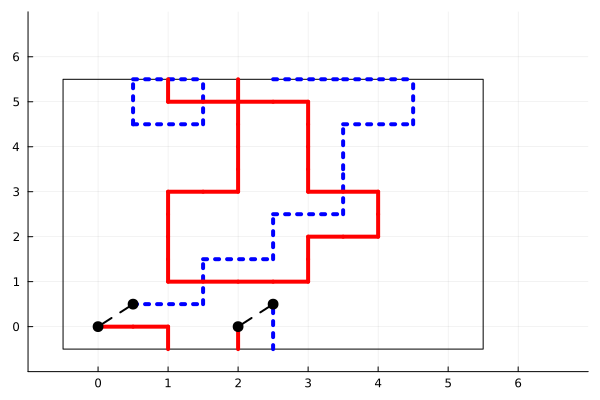

In [120]:
println("(0,1)\n")
visualise_the_stabiliser_dual(condensation_string_short((0,1), fermion_state, fermion_system, get_f_representative, f_deformator), fermion_system, [(0,0), (0,1)])
println("(2,0)\n")
visualise_the_stabiliser_dual(condensation_string_short((2,0), fermion_state, fermion_system, get_f_representative, f_deformator), fermion_system, [(0,0), (2,0)])
